# COURSE: A deep understanding of deep learning

## SECTION: ANNs

### LECTURE: Multilayer ANNs

#### TEACHER: Mike X Cohen, sincxpress.com

##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210


In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def t2f(x: torch.Tensor) -> np.ndarray:
    return x.detach().cpu().numpy().flatten()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


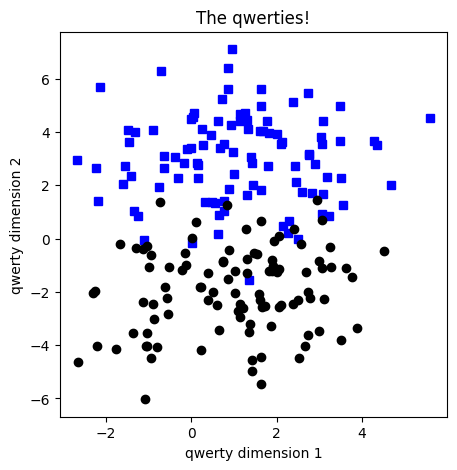

In [14]:
# create data

nPerClust = 100
blur = 1.6

A = [1, 3]
B = [1, -2]

# generate data
a = [A[0] + np.random.randn(nPerClust) * blur, A[1] + np.random.randn(nPerClust) * blur]
b = [B[0] + np.random.randn(nPerClust) * blur, B[1] + np.random.randn(nPerClust) * blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))))

# concatanate into a matrix
data_np = np.hstack((a, b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np, device=device).float()
labels = torch.tensor(labels_np, device=device).float()

# show the data
fig = plt.figure(figsize=(5, 5))
plt.plot(
    data_np[np.where(labels_np == 0)[0], 0],
    data_np[np.where(labels_np == 0)[0], 1],
    "bs",
)
plt.plot(
    data_np[np.where(labels_np == 1)[0], 0],
    data_np[np.where(labels_np == 1)[0], 1],
    "ko",
)
plt.title("The qwerties!")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()


# Functions to build and train the model


In [15]:
class ANNclassify(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # model architecture
        self.input = nn.Linear(2,16)
        self.hidden = nn.Linear(16,16)
        self.output = nn.Linear(16,1)

    def forward(self, x):
        x = self.input(x)
        x = x.relu()
        x = self.hidden(x)
        x = x.relu()
        x = self.output(x)
        x = x.sigmoid()
        return x

net = ANNclassify().cuda()
# loss function
lossfun = nn.BCELoss()  # but better to use BCEWithLogitsLoss
learning_rate = 0.1
# optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)


In [16]:
# a function that trains the model

# a fixed parameter
numepochs = 1000


def trainTheModel(ANNmodel, lossfun, optimizer):

    # initialize losses
    losses = torch.zeros(numepochs, device=device)

    # loop over epochs
    for epochi in range(numepochs):

        # forward pass
        yHat = ANNmodel(data)

        # compute loss
        loss = lossfun(yHat, labels)
        losses[epochi] = loss

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # final forward pass
    predictions = ANNmodel(data)

    # compute the predictions and report accuracy
    # NOTE: Wasn't this ">0" previously?!?!
    totalacc = 100 * torch.mean(((predictions > 0.5) == labels).float())

    return losses, predictions, totalacc


# Test the new code by running it once


Final accuracy: 94%


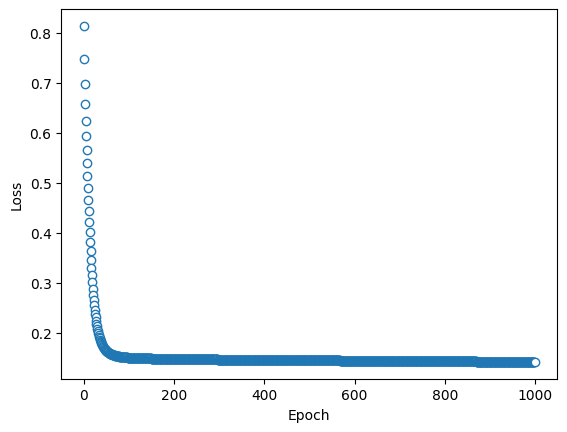

In [17]:
# run it
losses, predictions, totalacc = trainTheModel(net, lossfun, optimizer)

# report accuracy
print("Final accuracy: %g%%" % totalacc)


# show the losses
plt.plot(t2f(losses), "o", markerfacecolor="w", linewidth=0.1)
plt.xlabel("Epoch"), plt.ylabel("Loss")
plt.show()


# Now for the real test (varying learning rates)


In [19]:
# learning rates
learning_rates = np.linspace(0.001, 0.1, 50)

# initialize
accByLR = []
allLosses = np.zeros((len(learning_rates), numepochs))


# the loop
for i, lr in enumerate(learning_rates):

    # create and run the model
    losses, predictions, totalacc = trainTheModel(net, lossfun, optimizer)

    # store the results
    accByLR.append(totalacc)
    allLosses[i,:] = t2f(losses)


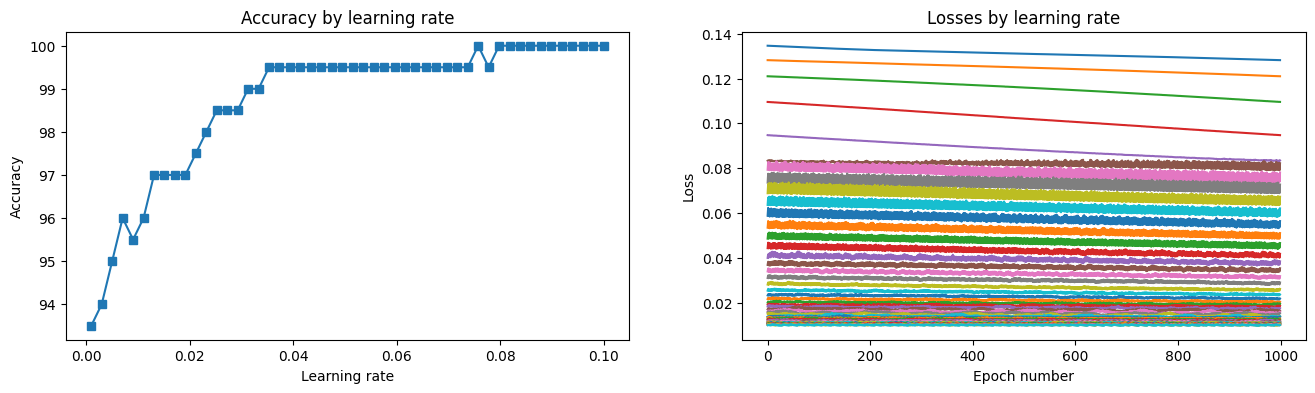

In [20]:
# plot the results
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(learning_rates, list(map(t2f, accByLR)), "s-")
ax[0].set_xlabel("Learning rate")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy by learning rate")

ax[1].plot(allLosses.T)
ax[1].set_title("Losses by learning rate")
ax[1].set_xlabel("Epoch number")
ax[1].set_ylabel("Loss")
plt.show()


In [21]:
accByLR


[tensor(93.5000, device='cuda:0'),
 tensor(94., device='cuda:0'),
 tensor(95., device='cuda:0'),
 tensor(96., device='cuda:0'),
 tensor(95.5000, device='cuda:0'),
 tensor(96., device='cuda:0'),
 tensor(97., device='cuda:0'),
 tensor(97., device='cuda:0'),
 tensor(97., device='cuda:0'),
 tensor(97., device='cuda:0'),
 tensor(97.5000, device='cuda:0'),
 tensor(98.0000, device='cuda:0'),
 tensor(98.5000, device='cuda:0'),
 tensor(98.5000, device='cuda:0'),
 tensor(98.5000, device='cuda:0'),
 tensor(99.0000, device='cuda:0'),
 tensor(99.0000, device='cuda:0'),
 tensor(99.5000, device='cuda:0'),
 tensor(99.5000, device='cuda:0'),
 tensor(99.5000, device='cuda:0'),
 tensor(99.5000, device='cuda:0'),
 tensor(99.5000, device='cuda:0'),
 tensor(99.5000, device='cuda:0'),
 tensor(99.5000, device='cuda:0'),
 tensor(99.5000, device='cuda:0'),
 tensor(99.5000, device='cuda:0'),
 tensor(99.5000, device='cuda:0'),
 tensor(99.5000, device='cuda:0'),
 tensor(99.5000, device='cuda:0'),
 tensor(99.5000, 

In [22]:
sum(torch.tensor(accByLR) > 70) / len(accByLR)


tensor(1.)

# Additional explorations


In [ ]:
# 1) The code creates a model with 16 hidden units. Notice where the two "16"s appear when constructing the model.
#    Recreate the model using 32 hidden units. Does that help with the issue of models getting stuck in local minima?
#
# 2) Adjust the code to create two hidden layers. The first hidden layer should have 16 hidden units and the second
#    hidden layer shuold have 32 units. What needs to change in the code to make the numbers match to prevent coding errors?
#
